In [1]:
from implementation_functions import *

import six
import sys
sys.modules['sklearn.externals.six'] = six
import mlrose

import pandas as pd
import numpy as np
from prince import FAMD #Factor analysis of mixed data
from aif360.metrics import BinaryLabelDatasetMetric
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import skfuzzy as fuzz

In [2]:
# SKIP THIS BLOCK IF YOU ARE ALREADY IMPORTING A DATAFRAME FROM A CSV(except sensitive attr and decision label definition)
data_name = "german"
dataset_orig, privileged_groups, unprivileged_groups = aif_data(data_name, False)

In [3]:
dataset_orig

               instance weights features                \
                                                         
                                   month credit_amount   
instance names                                           
0                           1.0      6.0        1169.0   
1                           1.0     48.0        5951.0   
2                           1.0     12.0        2096.0   
3                           1.0     42.0        7882.0   
4                           1.0     24.0        4870.0   
...                         ...      ...           ...   
995                         1.0     12.0        1736.0   
996                         1.0     30.0        3857.0   
997                         1.0     12.0         804.0   
998                         1.0     45.0        1845.0   
999                         1.0     45.0        4576.0   

                                                                \
                                                               

In [5]:
# Define sensitive attributes and decision label names for subroup label function
# Note: Sensitive attribute(s) must be always given as a list
sens_attr = ['age', 'sex']
decision_label = 'credit'
fav_l = 1
unfav_l = 0

In [4]:
metric_orig = BinaryLabelDatasetMetric(dataset_orig, 
                                              unprivileged_groups=unprivileged_groups,
                                              privileged_groups=privileged_groups)
print("Disparate impact (of original labels) between unprivileged and privileged groups = %f" % metric_orig.disparate_impact())
print("Difference in statistical parity (of original labels) between unprivileged and privileged groups = %f" % metric_orig.statistical_parity_difference())
print("Individual fairness metric that measures how similar the labels are for similar instances = %f" % metric_orig.consistency())

Disparate impact (of original labels) between unprivileged and privileged groups = 0.747630
Difference in statistical parity (of original labels) between unprivileged and privileged groups = -0.186462
Individual fairness metric that measures how similar the labels are for similar instances = 0.681600


c:\users\hatta\anaconda3\envs\aif360\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass n_neighbors=5 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [6]:
# Creating the snythetic sub-class label column and num-cat columns identification
orig_df, num_list, cat_list = preprocess(dataset_orig, sens_attr, decision_label)

# # The list of sub-group sizes in the dataset (to monitor the dist. of sub-groups)
# orig_df['sub_labels'].value_counts()
orig_df

,month,credit_amount,investment_as_income_percentage,residence_since,age,number_of_credits,people_liable_for,sex,status=A11,status=A12,...,skill_level=A171,skill_level=A172,skill_level=A173,skill_level=A174,telephone=A191,telephone=A192,foreign_worker=A201,foreign_worker=A202,credit,sub_labels
0,6.0,1169.0,4.0,4.0,1.0,2.0,1.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,7
1,48.0,5951.0,2.0,2.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0
2,12.0,2096.0,2.0,3.0,1.0,1.0,2.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,7
3,42.0,7882.0,2.0,4.0,1.0,1.0,2.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,7
4,24.0,4870.0,3.0,4.0,1.0,2.0,2.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,12.0,1736.0,3.0,4.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,3
996,30.0,3857.0,4.0,4.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,7
997,12.0,804.0,4.0,4.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,7
998,45.0,1845.0,4.0,4.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,4


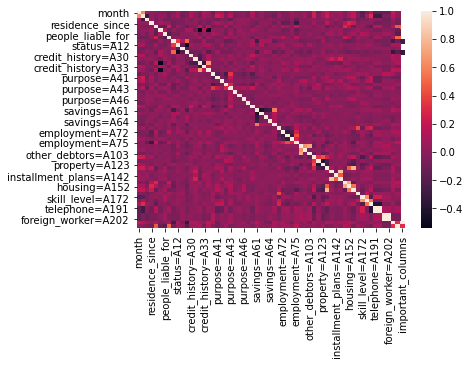

In [6]:
#check correlation of the columns
import seaborn as sns
res = orig_df.apply(lambda x : pd.factorize(x)[0] if (x.dtype == 'O') else x).corr(method='pearson', min_periods=1)
#check the correlation of features to the class labels
res.loc[res.iloc[:,58].abs() > 0.25, 'important_columns'] = res.iloc[:,58]
#plot(heatmap)
#plt.figure(figsize=(16,12))
_ = sns.heatmap(res)

In [7]:
# Train-test split WITH stratification
X = orig_df.loc[:, orig_df.columns != decision_label]
y = orig_df.loc[:, orig_df.columns == decision_label].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, 
                                                    shuffle=True,
                                                    stratify=X['sub_labels'])

In [8]:
# Check class imbalance in the splitted training set
print(X_train['sub_labels'].value_counts())
print(X_test['sub_labels'].value_counts())

# Partial feture scaling (of numerical variables)
X_train, X_test = scale(X_train, X_test)
num_list, cat_list = type_lists(X_train)

7    268
6     95
3     86
2     37
1     35
5     31
0     28
4     20
Name: sub_labels, dtype: int64
7    179
6     63
3     57
2     25
1     23
5     21
0     19
4     13
Name: sub_labels, dtype: int64


In [9]:
clf = RandomForestClassifier()
# Getting the baseline performance results from the imbalanced dataset
# Note: the function is created based on the assumption that the X's have sub_labels
# Instantiate the desired classifier obj to train the classification models    
baseline_stats, cm, ratio_table, preds = baseline_metrics(clf, X_train, X_test, 
                                                  y_train, y_test, sens_attr, 
                                                  fav_l, unfav_l)

In [10]:
print(baseline_stats)

                                              AEO Difference  \
[{'age': 0, 'sex': 0}][{'age': 1, 'sex': 0}]        0.025660   
[{'age': 1, 'sex': 0}][{'age': 0, 'sex': 1}]        0.048413   
[{'age': 0, 'sex': 1}][{'age': 1, 'sex': 1}]       -0.160804   
[{'age': 0, 'sex': 0}][{'age': 0, 'sex': 1}]        0.074073   
[{'age': 1, 'sex': 0}][{'age': 1, 'sex': 1}]       -0.112390   
[{'age': 0, 'sex': 0}][{'age': 1, 'sex': 1}]       -0.086731   

                                              Disparate Impact Ratio  \
[{'age': 0, 'sex': 0}][{'age': 1, 'sex': 0}]                0.960695   
[{'age': 1, 'sex': 0}][{'age': 0, 'sex': 1}]                1.135737   
[{'age': 0, 'sex': 1}][{'age': 1, 'sex': 1}]                0.768572   
[{'age': 0, 'sex': 0}][{'age': 0, 'sex': 1}]                1.091097   
[{'age': 1, 'sex': 0}][{'age': 1, 'sex': 1}]                0.872896   
[{'age': 0, 'sex': 0}][{'age': 1, 'sex': 1}]                0.838587   

                                              

In [11]:
print(cm)

{'TP': 257.0, 'FP': 73.0, 'TN': 47.0, 'FN': 23.0}


In [12]:
print(ratio_table)

                      Base Ratio  Positive Ratio  Negative Ratio
Index                                                           
{'age': 0, 'sex': 0}       0.105          0.0775          0.0275
{'age': 1, 'sex': 0}       0.205          0.1575          0.0475
{'age': 0, 'sex': 1}       0.085          0.0575          0.0275
{'age': 1, 'sex': 1}       0.605          0.5325          0.0725


In [13]:
# Keep the subgroup labels to append them back later
keep_sub_l = X_train['sub_labels']

# Required drops for the GERMAN dataset (THIS DF CREATION IS A MUST)
X_train_new = X_train.drop(['age', 'sex', 'sub_labels'], axis=1)

# Get the idx of categ and numeric columns again due to the column drops above
num_list, cat_list = type_lists(X_train_new)

In [15]:
X_train_new

,0,1,2,3,4,people_liable_for,status=A11,status=A12,status=A13,status=A14,...,housing=A152,housing=A153,skill_level=A171,skill_level=A172,skill_level=A173,skill_level=A174,telephone=A191,telephone=A192,foreign_worker=A201,foreign_worker=A202
0,0.161765,0.033838,1.000000,0.666667,0.333333,2,1,0,0,0,...,0,0,0,0,1,0,1,0,1,0
1,0.558824,0.222935,0.666667,0.333333,0.333333,2,1,0,0,0,...,1,0,0,0,1,0,0,1,1,0
2,0.294118,0.241845,1.000000,0.333333,0.333333,1,0,1,0,0,...,1,0,0,0,0,1,0,1,1,0
3,0.250000,0.123963,1.000000,0.333333,0.000000,2,0,0,0,1,...,1,0,0,1,0,0,1,0,1,0
4,0.294118,0.204799,0.666667,1.000000,0.333333,1,0,0,0,1,...,1,0,0,0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.294118,0.133916,1.000000,1.000000,0.000000,1,0,1,0,0,...,0,1,0,0,1,0,0,1,1,0
596,0.161765,0.180029,0.000000,0.333333,0.333333,1,0,0,0,1,...,1,0,0,1,0,0,1,0,1,0
597,0.470588,0.200210,1.000000,0.666667,0.000000,1,1,0,0,0,...,1,0,0,0,0,1,0,1,1,0
598,0.294118,0.052361,1.000000,1.000000,0.000000,1,1,0,0,0,...,0,0,0,0,1,0,1,0,1,0


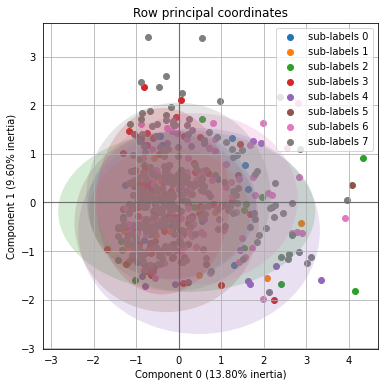

In [16]:
# Dimensionality reduction for big datasets with FAMD
X_train_new['sub_labels'] = keep_sub_l

famd = FAMD(n_components=2, random_state = 42)
famd.fit(X_train_new.drop('sub_labels', axis=1))
X_train_reduc = famd.transform(X_train_new)
#plotting the reduced dimensions
ax = famd.plot_row_coordinates(X_train_new, 
                                 color_labels=['sub-labels {}'.format(t) for t in X_train_new['sub_labels']])
# X_train_red = famd.partial_row_coordinates(X_train_new)
# famd.explained_inertia_
# ax = famd.plot_partial_row_coordinates(X_train_new, 
#                                         color_labels=['sub-labels {}'.format(t) for t in X_train_new['sub_labels']])
                               
# Delete the subgroup label column again if dimensionality reduction is used
X_train_new = X_train_new.drop(['sub_labels'], axis=1)

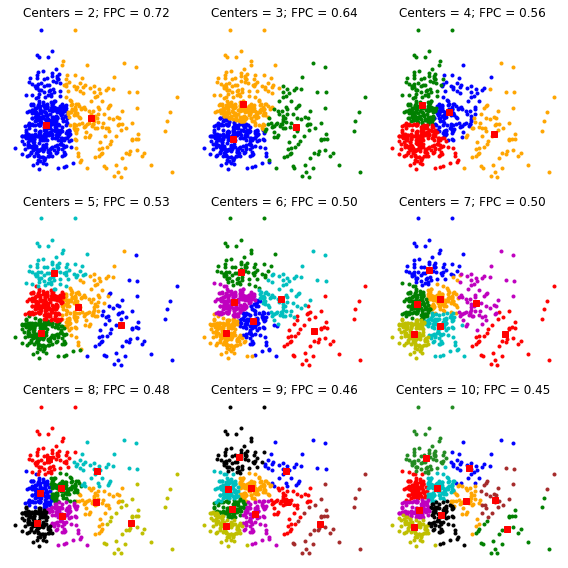

In [18]:
#clustering implementation with fuzzy c-means
alldata = np.vstack((X_train_reduc[0], X_train_reduc[1]))
#Set up the loop and plot
colors = ['b', 'orange', 'g', 'r', 'c', 'm', 'y', 'k', 'Brown', 'ForestGreen']
fig1, axes1 = plt.subplots(3, 3, figsize=(8, 8))
fpcs = []

#checking for the optimal num of clusters with FPC plots
for ncenters, ax in enumerate(axes1.reshape(-1), 2):
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        alldata, ncenters, 2, error=0.005, maxiter=1000, init=None)

    # Store fpc values for later
    fpcs.append(fpc)

    # Plot assigned clusters, for each data point in training set
    cluster_membership = np.argmax(u, axis=0)
    for j in range(ncenters):
        ax.plot(X_train_reduc[0][cluster_membership == j],
                X_train_reduc[1][cluster_membership == j], '.', color=colors[j])

    # Mark the center of each fuzzy cluster
    for pt in cntr:
        ax.plot(pt[0], pt[1], 'rs')

    ax.set_title('Centers = {0}; FPC = {1:.2f}'.format(ncenters, fpc))
    ax.axis('off')
fig1.tight_layout()

Text(0, 0.5, 'Fuzzy partition coefficient')

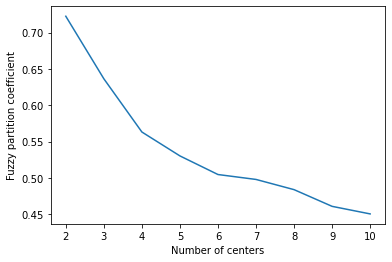

In [21]:
#fpc plot per number of clusters
fig2, ax2 = plt.subplots()
ax2.plot(np.r_[2:11], fpcs)
ax2.set_xlabel("Number of centers")
ax2.set_ylabel("Fuzzy partition coefficient")

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.90it/s]


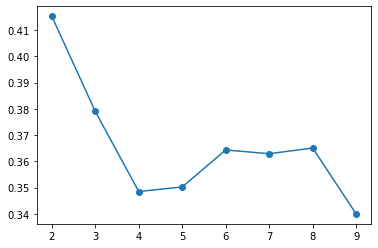

In [22]:
#silhouette score plot per number of cluster
from tqdm import tqdm
n_clusters = []
silhouette_scores = []
for i in tqdm(range(2, 10)):
    try:
        cntr, u_orig, _, _, _, _, _ = fuzz.cluster.cmeans(alldata, i, 2, error=0.005, 
                                                          maxiter=5000)
        u, u0, d, jm, p, fpc = fuzz.cluster.cmeans_predict(X_train_reduc.T, cntr, 2, error=0.005,       
                                                            maxiter=5000)
        clusters = np.argmax(u, axis=0)
        silhouette_val = silhouette_score(X_train_reduc, clusters, 
                                          metric='euclidean')
        silhouette_scores.append(silhouette_val)
        n_clusters.append(i)
    except:
        print(f"Can't cluster with {i} clusters")
plt.scatter(x=n_clusters, y=silhouette_scores)
plt.plot(n_clusters, silhouette_scores)
plt.show()

In [23]:
#predict with the num of clusters desired
n_clust = 4
cntr, u_orig, _, _, _, _, _ = fuzz.cluster.cmeans(alldata, n_clust, 2, error=0.005, 
                                                  maxiter=5000)
# u: final fuzzy-partitioned matrix, u0: initial guess at fuzzy c-partitioned matrix,
# d: final euclidean distance matrix, jm: obj func hist, p: num of iter run, 
#fpc: fuzzy partition coefficient
u, u0, d, jm, p, fpc = fuzz.cluster.cmeans_predict(X_train_reduc.T, cntr, 2, error=0.005,       
                                                   maxiter=5000)
clusters = np.argmax(u, axis=0)  # Hardening for silhouette   
print(silhouette_score(X_train_reduc, clusters, metric='euclidean'))

0.3491676430061137


In [24]:
# Putting the required label info back to the dataframe before oversampling
X_train_new['cluster_labels'] = clusters
X_train_new['cluster_labels'] = X_train_new['cluster_labels'].astype('object')
X_train_new['sub_labels'] = keep_sub_l
# Also put the original decision labels so that they are also oversampled
X_train_new['class_labels'] = y_train

In [25]:
#cluster datasets in their original form
existing_clust = {}
for h in range(len(X_train_new['cluster_labels'].unique())):
   existing_clust[h] = X_train_new.loc[X_train_new['cluster_labels']==h]
#checking the subgroup counts in each cluster dataset
for item in existing_clust:
    print(existing_clust[item]['sub_labels'].value_counts())

#fixing the cluster memberships in each df if a sample from a subgroup is alone
fixed_clusters = fix_memberships_fcm(X_train_new, X_train_reduc, clust_centroids=cntr)
#checking the subgroup counts in each cluster dataset
for item in fixed_clusters:
    print(fixed_clusters[item]['sub_labels'].value_counts())

7    88
3    36
6    18
1    12
0     8
5     7
2     7
4     2
Name: sub_labels, dtype: int64
7    86
3    30
6    26
5    21
2    15
1    14
0    10
4     8
Name: sub_labels, dtype: int64
7    29
6    18
2     8
4     6
3     3
1     2
0     2
5     1
Name: sub_labels, dtype: int64
7    65
6    33
3    17
0     8
2     7
1     7
4     4
5     2
Name: sub_labels, dtype: int64
7    88
3    36
6    18
1    12
0     8
5     7
2     7
4     2
Name: sub_labels, dtype: int64
7    86
3    30
6    26
5    21
2    15
1    14
0    10
4     8
Name: sub_labels, dtype: int64
7    29
6    18
2     8
4     6
3     3
1     2
0     2
Name: sub_labels, dtype: int64
7    65
6    33
3    17
0     8
2     7
1     7
4     4
5     3
Name: sub_labels, dtype: int64


In [26]:
#transform the data types of all the columns to numeric for SMOTE
for df in fixed_clusters:
    for i in range(len(fixed_clusters[df].columns)):       
        fixed_clusters[df].iloc[:,i] = fixed_clusters[df].iloc[:,i].astype('float')

# Over-sampling of each cluster
oversampled_clusters, unique_subl = oversample(fixed_clusters)
for item in oversampled_clusters:
    print(oversampled_clusters[item]['sub_labels'].value_counts())

# Deleting sensitive attributes and subgroup labels from test set is required
# to apply the implemented solutions (sens. attr. are not used to satisfy the
# disparate treatment in the functions)
test_sublabels = X_test['sub_labels']
X_test_n = X_test.drop(['age', 'sex','sub_labels'], axis=1)
num_list, cat_list = type_lists(X_test_n)
X_test_reduc = famd.transform(X_test_n)

7    88
6    88
5    88
4    88
3    88
2    88
1    88
0    88
Name: sub_labels, dtype: int64
7    86
6    86
5    86
4    86
3    86
2    86
1    86
0    86
Name: sub_labels, dtype: int64
7    29
6    29
4    29
3    29
2    29
1    29
0    29
Name: sub_labels, dtype: int64
7    65
6    65
5    65
4    65
3    65
2    65
1    65
0    65
Name: sub_labels, dtype: int64


### CLASS LABEL PREDICTIONS PER STRATEGY

In [27]:
# Predicting the test sets based on strategy 1
X_test_pred1 = predict_whole_set(clf, oversampled_clusters, X_test_n)

# Predicting the test sets based on strategy 2   
#t_u is needed later for option 3
t_u, u0, d, jm, p, fpc = fuzz.cluster.cmeans_predict(
    X_test_reduc.T, cntr, 2, error=0.005, maxiter=1000)
test_clusts = np.argmax(t_u, axis=0) 
X_test_pred2 = predict_w_fuzzy(clf, oversampled_clusters, X_test_n, 
                               X_test_reduc, cntr, unique_subl, test_sublabels)

# Predicting the test sets based on strategy 3
X_test_pred3 = predict_w_weights_fuzzy(clf, oversampled_clusters, t_u, 
                                       X_test_n, unique_subl, test_sublabels)

#### The metrics table creation for given dataset: Protected attributes and groups must be defined based on the dataset and preferences to calculate fairness and performance metrics

In [28]:
metrics_table1, cm1, ratio_t1 = metrics_calculate(X_test, X_test_pred1, y_test,
                                                  sens_attr, fav_l, unfav_l)
metrics_table2, cm2, ratio_t2 = metrics_calculate(X_test, X_test_pred2, y_test,
                                                  sens_attr, fav_l, unfav_l)
metrics_table3, cm3, ratio_t3 = metrics_calculate(X_test, X_test_pred3, y_test,
                                                  sens_attr, fav_l, unfav_l)

In [30]:
#outputs from strategy 1
print(metrics_table1)
print("Confusion Matrix:", cm1)
print(ratio_t1)

                                              AEO Difference  \
[{'age': 0, 'sex': 0}][{'age': 1, 'sex': 0}]        0.064943   
[{'age': 1, 'sex': 0}][{'age': 0, 'sex': 1}]        0.083501   
[{'age': 0, 'sex': 1}][{'age': 1, 'sex': 1}]       -0.130964   
[{'age': 0, 'sex': 0}][{'age': 0, 'sex': 1}]        0.148444   
[{'age': 1, 'sex': 0}][{'age': 1, 'sex': 1}]       -0.047463   
[{'age': 0, 'sex': 0}][{'age': 1, 'sex': 1}]        0.017480   

                                              Disparate Impact Ratio  \
[{'age': 0, 'sex': 0}][{'age': 1, 'sex': 0}]                0.990760   
[{'age': 1, 'sex': 0}][{'age': 0, 'sex': 1}]                1.207847   
[{'age': 0, 'sex': 1}][{'age': 1, 'sex': 1}]                0.794689   
[{'age': 0, 'sex': 0}][{'age': 0, 'sex': 1}]                1.196687   
[{'age': 1, 'sex': 0}][{'age': 1, 'sex': 1}]                0.959863   
[{'age': 0, 'sex': 0}][{'age': 1, 'sex': 1}]                0.950994   

                                              

In [31]:
#outputs from strategy 2
print(metrics_table2)
print("Confusion Matrix:", cm2)
print(ratio_t2)

                                              AEO Difference  \
[{'age': 0, 'sex': 0}][{'age': 1, 'sex': 0}]        0.000748   
[{'age': 1, 'sex': 0}][{'age': 0, 'sex': 1}]        0.099641   
[{'age': 0, 'sex': 1}][{'age': 1, 'sex': 1}]       -0.076872   
[{'age': 0, 'sex': 0}][{'age': 0, 'sex': 1}]        0.100389   
[{'age': 1, 'sex': 0}][{'age': 1, 'sex': 1}]        0.022769   
[{'age': 0, 'sex': 0}][{'age': 1, 'sex': 1}]        0.023517   

                                              Disparate Impact Ratio  \
[{'age': 0, 'sex': 0}][{'age': 1, 'sex': 0}]                0.961172   
[{'age': 1, 'sex': 0}][{'age': 0, 'sex': 1}]                1.171792   
[{'age': 0, 'sex': 1}][{'age': 1, 'sex': 1}]                0.843845   
[{'age': 0, 'sex': 0}][{'age': 0, 'sex': 1}]                1.126294   
[{'age': 1, 'sex': 0}][{'age': 1, 'sex': 1}]                0.988811   
[{'age': 0, 'sex': 0}][{'age': 1, 'sex': 1}]                0.950417   

                                              

In [32]:
#outputs from strategy 3
print(metrics_table3)
print("Confusion Matrix:", cm3)
print(ratio_t3)

                                              AEO Difference  \
[{'age': 0, 'sex': 0}][{'age': 1, 'sex': 0}]       -0.001373   
[{'age': 1, 'sex': 0}][{'age': 0, 'sex': 1}]        0.067881   
[{'age': 0, 'sex': 1}][{'age': 1, 'sex': 1}]       -0.071821   
[{'age': 0, 'sex': 0}][{'age': 0, 'sex': 1}]        0.066508   
[{'age': 1, 'sex': 0}][{'age': 1, 'sex': 1}]       -0.003940   
[{'age': 0, 'sex': 0}][{'age': 1, 'sex': 1}]       -0.005313   

                                              Disparate Impact Ratio  \
[{'age': 0, 'sex': 0}][{'age': 1, 'sex': 0}]                0.946609   
[{'age': 1, 'sex': 0}][{'age': 0, 'sex': 1}]                1.189820   
[{'age': 0, 'sex': 1}][{'age': 1, 'sex': 1}]                0.822643   
[{'age': 0, 'sex': 0}][{'age': 0, 'sex': 1}]                1.126294   
[{'age': 1, 'sex': 0}][{'age': 1, 'sex': 1}]                0.978796   
[{'age': 0, 'sex': 0}][{'age': 1, 'sex': 1}]                0.926537   

                                              